### Imports e utilitários

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

global_seed = 1


### Funções objetivo e domínios

In [ ]:


def f1(x):
    x1, x2 = x
    return x1**2 + x2**2

bounds1 = [(-100, 100), (-100, 100)]
goal1 = "min"


def f2(x):
    x1, x2 = x
    # f(x1, x2) = exp(-(x1^2 + x2^2)) + 2 * exp(-(x1-1.7)^2 - (x2-1.7)^2)
    return math.exp(-(x1**2 + x2**2)) + 2 * math.exp(-((x1-1.7)**2 + (x2-1.7)**2))

bounds2 = [(-2, 4), (-2, 5)]
goal2 = "max"


def f3(x):
    x1, x2 = x
    term1 = -20 * math.exp(-0.2 * math.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = - math.exp(0.5 * (math.cos(2*math.pi*x1) + math.cos(2*math.pi*x2)))
    return term1 + term2 + 20 + math.e

bounds3 = [(-8, 8), (-8, 8)]
goal3 = "min"


def f4(x):
    x1, x2 = x
    return (x1**2 - 10 * math.cos(2*math.pi*x1) + 10) + \
           (x2**2 - 10 * math.cos(2*math.pi*x2) + 10)

bounds4 = [(-5.12, 5.12), (-5.12, 5.12)]
goal4 = "min"


def f5(x):
    x1, x2 = x
    # f(x1,x2) = x1*cos(x1)/20 + 2*exp(-(x1^2 + (x2-1)^2)) + 0.01*x1*x2
    return (x1 * math.cos(x1) / 20.0) + \
           2 * math.exp(-(x1**2 + (x2-1)**2)) + \
           0.01 * x1 * x2

bounds5 = [(-10, 10), (-10, 10)]
goal5 = "max"


def f6(x):
    x1, x2 = x
    # f(x1,x2) = x1*sin(4*pi*x1) - x2*sin(4*pi*x2 + pi) + 1
    return x1 * math.sin(4*math.pi*x1) - x2 * math.sin(4*math.pi*x2 + math.pi) + 1.0

bounds6 = [(-1, 3), (-1, 3)]
goal6 = "max"


problems = [
    (f1, bounds1, goal1),
    (f2, bounds2, goal2),
    (f3, bounds3, goal3),
    (f4, bounds4, goal4),
    (f5, bounds5, goal5),
    (f6, bounds6, goal6),
]


### Funções auxiliares de avaliação e clipping

In [ ]:
def clip_to_bounds(x, bounds):
    x_clipped = np.empty_like(x, dtype=float)
    for i, (lo, hi) in enumerate(bounds):
        x_clipped[i] = np.clip(x[i], lo, hi)
    return x_clipped


def better(fx_new, fx_best, goal):
    if goal == "min":
        return fx_new < fx_best
    else:
        return fx_new > fx_best


### Hill Climbing (HC)

In [ ]:
class HillClimbing:
    def __init__(self, func, bounds, goal,
                 eps=0.1, max_it=1000, t_no_improve=50, rng=None):
        self.func = func
        self.bounds = bounds
        self.goal = goal
        self.eps = eps
        self.max_it = max_it
        self.t_no_improve = t_no_improve
        self.rng = rng or np.random.default_rng()

        self.x_opt = self.initial_point()
        self.f_opt = self.func(self.x_opt)
        self.it = 0
        self.it_since_improve = 0

        self.history_x = [self.x_opt.copy()]
        self.history_f = [self.f_opt]

    def initial_point(self):
        x = np.array([b[0] for b in self.bounds], dtype=float)
        return clip_to_bounds(x, self.bounds)

    def initial_point(self):
        x = np.array(
            [self.rng.uniform(lo, hi) for (lo, hi) in self.bounds],
            dtype=float,
        )
        return clip_to_bounds(x, self.bounds)

    def better(self, f_new, f_old):
        return better(f_new, f_old, self.goal)

    def step(self):
        if self.it >= self.max_it or self.it_since_improve >= self.t_no_improve:
            return False

        cand = self.neighbor()
        f_cand = self.func(cand)

        if self.better(f_cand, self.f_opt):
            self.x_opt = cand
            self.f_opt = f_cand
            self.it_since_improve = 0
        else:
            self.it_since_improve += 1

        self.it += 1
        self.history_x.append(self.x_opt.copy())
        self.history_f.append(self.f_opt)
        return True

    def search(self):
        while self.step():
            pass
        return self.x_opt, self.f_opt


### Local Random Search (LRS)

In [ ]:
class LocalRandomSearch:
    def __init__(self, func, bounds, goal,
                 sigma=0.1, max_it=1000, t_no_improve=50, rng=None):
        self.func = func
        self.bounds = bounds
        self.goal = goal
        self.sigma = sigma
        self.max_it = max_it
        self.t_no_improve = t_no_improve
        self.rng = rng or np.random.default_rng()

        self.x_opt = self.sample_initial()
        self.f_opt = self.func(self.x_opt)
        self.it = 0
        self.it_since_improve = 0

        self.history_x = [self.x_opt.copy()]
        self.history_f = [self.f_opt]

    def sample_initial(self):
        x = np.array(
            [self.rng.uniform(lo, hi) for (lo, hi) in self.bounds],
            dtype=float
        )
        return clip_to_bounds(x, self.bounds)

    def perturb(self):
        step = self.rng.normal(loc=0.0, scale=self.sigma, size=len(self.bounds))
        cand = clip_to_bounds(self.x_opt + step, self.bounds)
        return cand

    def better(self, f_new, f_old):
        return better(f_new, f_old, self.goal)

    def step(self):
        if self.it >= self.max_it or self.it_since_improve >= self.t_no_improve:
            return False

        cand = self.perturb()
        f_cand = self.func(cand)

        if self.better(f_cand, self.f_opt):
            self.x_opt = cand
            self.f_opt = f_cand
            self.it_since_improve = 0
        else:
            self.it_since_improve += 1

        self.it += 1
        self.history_x.append(self.x_opt.copy())
        self.history_f.append(self.f_opt)
        return True

    def search(self):
        while self.step():
            pass
        return self.x_opt, self.f_opt

### Global Random Search (GRS)

In [ ]:
class GlobalRandomSearch:
    def __init__(self, func, bounds, goal, max_it=1000, t_no_improve=50, rng=None):
        self.func = func
        self.bounds = bounds
        self.goal = goal
        self.max_it = max_it
        self.t_no_improve = t_no_improve
        self.rng = rng or np.random.default_rng()

        self.x_opt = self.sample_point()
        self.f_opt = self.func(self.x_opt)

        self.it = 0
        self.it_since_improve = 0
        self.history_x = [self.x_opt.copy()]
        self.history_f = [self.f_opt]

    def sample_point(self):
        x = np.array(
            [self.rng.uniform(lo, hi) for (lo, hi) in self.bounds],
            dtype=float
        )
        return clip_to_bounds(x, self.bounds)

    def better(self, f_new, f_old):
        return better(f_new, f_old, self.goal)

    def step(self):
        if self.it >= self.max_it or self.it_since_improve >= self.t_no_improve:
            return False

        cand = self.sample_point()
        f_cand = self.func(cand)

        if self.better(f_cand, self.f_opt):
            self.x_opt = cand
            self.f_opt = f_cand
            self.it_since_improve = 0
        else:
            self.it_since_improve += 1

        self.it += 1
        self.history_x.append(self.x_opt.copy())
        self.history_f.append(self.f_opt)

        return True

    def search(self):
        while self.step():
            pass
        return self.x_opt, self.f_opt


### Execução de 100 rodadas e moda das soluções

In [ ]:
def run_experiment_problem(func, bounds, goal,
                           R=100,
                           max_it=1000,
                           t_no_improve=50,
                           eps_hc=0.1,
                           sigma_lrs=0.1,
                           sigma_grs=0.1,
                           seed=42):
    rng = np.random.default_rng(seed)

    results = {
        "HC": [],
        "LRS": [],
        "GRS": [],
    }

    for r in range(R):
        hc = HillClimbing(
            func=func,
            bounds=bounds,
            goal=goal,
            eps=eps_hc,
            max_it=max_it,
            t_no_improve=t_no_improve,
            rng=rng
        )
        x_hc, fx_hc = hc.search()
        results["HC"].append((x_hc, fx_hc))

        lrs = LocalRandomSearch(
            func=func,
            bounds=bounds,
            goal=goal,
            sigma=sigma_lrs,
            max_it=max_it,
            t_no_improve=t_no_improve,
            rng=rng
        )
        x_lrs, fx_lrs = lrs.search()
        results["LRS"].append((x_lrs, fx_lrs))

        grs = GlobalRandomSearch(
            func=func,
            bounds=bounds,
            goal=goal,
            max_it=max_it,
            t_no_improve=t_no_improve,
            rng=rng
        )
        x_grs, fx_grs = grs.search()
        results["GRS"].append((x_grs, fx_grs))

    return results


def results_mode(results, decimals=3):
    modes = {}
    for alg_name, runs in results.items():
        keys = []
        for x, fx in runs:
            x_rounded = tuple(np.round(x, decimals))
            fx_rounded = round(float(fx), decimals)
            keys.append((x_rounded, fx_rounded))
        counts = Counter(keys)
        mode, freq = counts.most_common(1)[0]
        modes[alg_name] = (mode, freq)
    return modes

### Varredura de hiperparâmetros para achar o menor valor que encontra a solução ótima

In [ ]:
def find_best_hyperparameter_for_problem(
    problem_idx,
    func, bounds, goal,
    algorithm_type,
    hp_list,
    R=100,
    max_it=1000,
    t_no_improve=50,
    decimals=3,
    base_seed=1000
):
    records = []

    for i_hp, hp in enumerate(hp_list):
        seed = base_seed + problem_idx * 10 + i_hp
        rng = np.random.default_rng(seed)

        results = {algorithm_type: []}

        for r in range(R):
            if algorithm_type == "HC":
                optimizer = HillClimbing(
                    func=func,
                    bounds=bounds,
                    goal=goal,
                    eps=hp,
                    max_it=max_it,
                    t_no_improve=t_no_improve,
                    rng=rng
                )
            elif algorithm_type == "LRS":
                optimizer = LocalRandomSearch(
                    func=func,
                    bounds=bounds,
                    goal=goal,
                    sigma=hp,
                    max_it=max_it,
                    t_no_improve=t_no_improve,
                    rng=rng
                )
            elif algorithm_type == "GRS":
                optimizer = GlobalRandomSearch(
                    func=func,
                    bounds=bounds,
                    goal=goal,
                    max_it=max_it,
                    t_no_improve=t_no_improve,
                    rng=rng
                )
            else:
                raise ValueError("tipo_algoritmo deve ser 'HC', 'LRS' ou 'GRS'.")

            x, fx = optimizer.search()
            results[algorithm_type].append((x, fx))

        modes = results_mode(results, decimals=decimals)
        (x_rounded, f_rounded), freq = modes[algorithm_type]
        proportion = freq / R

        records.append({
            "problem": problem_idx,
            "algorithm": algorithm_type,
            "hyperparameter": hp,
            "x_mode": x_rounded,
            "f_mode": f_rounded,
            "freq_mode": freq,
            "R": R,
            "proportion": proportion,
        })

    return pd.DataFrame(records)

### Rodar varredura de hiperparâmetros para todos os problemas

In [ ]:

eps_list_hc = [0.5, 0.2, 0.1, 0.05, 0.01]
sigma_list_lrs = [0.5, 0.2, 0.1, 0.05, 0.01]
sigma_list_grs = [0.5, 0.2, 0.1, 0.05, 0.01]

R = 100
max_it = 1000
t_no_improve = 50

dfs_hp = []

for idx, (func, bounds, goal) in enumerate(problems, start=1):
    print(f"=== Problema {idx} ({goal}) – HC (eps) ===")
    df_hc = find_best_hyperparameter_for_problem(
        problem_idx=idx,
        func=func,
        bounds=bounds,
        goal=goal,
        algorithm_type="HC",
        hp_list=eps_list_hc,
        R=R,
        max_it=max_it,
        t_no_improve=t_no_improve,
        decimals=3,
        base_seed=2000
    )
    display(df_hc)
    dfs_hp.append(df_hc)

    print(f"\n=== Problema {idx} ({goal}) – LRS (sigma) ===")
    df_lrs = find_best_hyperparameter_for_problem(
        problem_idx=idx,
        func=func,
        bounds=bounds,
        goal=goal,
        algorithm_type="LRS",
        hp_list=sigma_list_lrs,
        R=R,
        max_it=max_it,
        t_no_improve=t_no_improve,
        decimals=3,
        base_seed=3000
    )
    display(df_lrs)
    dfs_hp.append(df_lrs)

    print(f"\n=== Problema {idx} ({goal}) – GRS (sigma) ===")
    df_grs = find_best_hyperparameter_for_problem(
        problem_idx=idx,
        func=func,
        bounds=bounds,
        goal=goal,
        algorithm_type="GRS",
        hp_list=sigma_list_grs,
        R=R,
        max_it=max_it,
        t_no_improve=t_no_improve,
        decimals=3,
        base_seed=4000
    )
    display(df_grs)
    dfs_hp.append(df_grs)

df_hyperparameters = pd.concat(dfs_hp, ignore_index=True)


=== Problema 1 (min) – HC (eps) ===


AttributeError: 'HillClimbing' object has no attribute 'neighbor'

### Identificar o “menor hiperparâmetro que encontra a solução ótima”

In [ ]:
def select_smallest_good_hp(df_hp):
    rows = []

    for (problem, algorithm), group in df_hp.groupby(["problem", "algorithm"]):
        # ordena por proporcao desc, hiperparametro asc
        group_sorted = group.sort_values(
            by=["proportion", "hyperparameter"],
            ascending=[False, True]
        )
        best = group_sorted.iloc[0]
        rows.append(best)

    return pd.DataFrame(rows).reset_index(drop=True)


df_best_hps = select_smallest_good_hp(df_hyperparameters)
df_best_hps


,problem,algorithm,hyperparameter,x_mode,f_mode,freq_mode,R,proportion
0,1,GRS,0.01,"(5.176, -0.086)",26.795,1,100,0.01
1,1,HC,0.01,"(-98.271, -98.228)",19305.936,1,100,0.01
2,1,LRS,0.20,"(0.027, 0.019)",0.001,2,100,0.02
3,2,GRS,0.01,"(1.754, 0.94)",1.139,1,100,0.01
4,2,HC,0.05,"(0.013, 0.011)",1.006,4,100,0.04
5,2,LRS,0.01,"(0.011, 0.012)",1.006,9,100,0.09
6,3,GRS,0.01,"(-0.148, -0.479)",3.264,1,100,0.01
7,3,HC,0.50,"(-8.0, -8.0)",15.962,43,100,0.43
8,3,LRS,0.01,"(-3.984, 3.983)",10.998,1,100,0.01
9,4,GRS,0.01,"(1.995, 0.963)",5.184,1,100,0.01


### Rodar para todos os 6 problemas e montar tabela de modas

In [ ]:
R = 100
max_it = 1000
t_no_improve = 50

modes_table = []

for idx, (func, bounds, goal) in enumerate(problems, start=1):
    tipo_objetivo = "MINIMIZAÇÃO" if goal == "min" else "MAXIMIZAÇÃO"

    print("=" * 70)
    print(f"Problema {idx} - {tipo_objetivo}")
    print(f"  Objetivo (goal)        : {goal}  ('min' = minimizar, 'max' = maximizar)")
    print(f"  Número de rodadas (R)  : {R}")
    print("-" * 70)

    best_hp_problem = df_best_hps[df_best_hps["problem"] == idx]

    eps_hc = best_hp_problem.loc[
        best_hp_problem["algorithm"] == "HC", "hyperparameter"
    ].iloc[0]

    sigma_lrs = best_hp_problem.loc[
        best_hp_problem["algorithm"] == "LRS", "hyperparameter"
    ].iloc[0]

    sigma_grs = best_hp_problem.loc[
        best_hp_problem["algorithm"] == "GRS", "hyperparameter"
    ].iloc[0]

    print("Hiperparâmetros escolhidos para este problema (a partir da moda):")
    print(f"  HC  (eps)   = {eps_hc}")
    print(f"  LRS (sigma) = {sigma_lrs}")
    print(f"  GRS (sigma) = {sigma_grs}")
    print("-" * 70)

    results = run_experiment_problem(
        func, bounds, goal,
        R=R,
        max_it=max_it,
        t_no_improve=t_no_improve,
        eps_hc=eps_hc,
        sigma_lrs=sigma_lrs,
        sigma_grs=sigma_grs,
        seed=global_seed + idx,
    )

    modes = results_mode(results, decimals=3)

    print(f"Resultados (moda das soluções nas {R} rodadas):")
    print(f"{'Algoritmo':<10} {'Hiperparâmetro':<18} {'x* (moda)':<30} {'f(x*) (moda)':<15} {'Frequência':<12}")
    for alg, (sol, freq) in modes.items():
        x_rounded, fx_rounded = sol

        if alg == "HC":
            hp_value = eps_hc
            hp_name = "eps"
        elif alg == "LRS":
            hp_value = sigma_lrs
            hp_name = "sigma"
        else:  # "GRS"
            hp_value = sigma_grs
            hp_name = "sigma"

        print(f"{alg:<10} {hp_name+'='+str(hp_value):<18} {str(x_rounded):<30} {str(fx_rounded):<15} {f'{freq}/{R}':<12}")

        modes_table.append({
            "indice_problema": idx,           
            "objetivo": goal,                 
            "algoritmo": alg,                 
            "nome_hiperparametro": hp_name,   
            "valor_hiperparametro": hp_value, 
            "x_moda": x_rounded,              
            "fx_moda": fx_rounded,            
            "frequencia_moda": freq,          
            "numero_rodadas": R               
        })

    print()


Problema 1 - MINIMIZAÇÃO
  Objetivo (goal)        : min  ('min' = minimizar, 'max' = maximizar)
  Número de rodadas (R)  : 100
----------------------------------------------------------------------
Hiperparâmetros escolhidos para este problema (a partir da moda):
  HC  (eps)   = 0.01
  LRS (sigma) = 0.2
  GRS (sigma) = 0.01
----------------------------------------------------------------------
Resultados (moda das soluções nas 100 rodadas):
Algoritmo  Hiperparâmetro     x* (moda)                      f(x*) (moda)    Frequência  
HC         eps=0.01           (np.float64(-98.236), np.float64(-98.391)) 19331.121       1/100       
LRS        sigma=0.2          (np.float64(1.217), np.float64(18.978)) 361.627         1/100       
GRS        sigma=0.01         (np.float64(-3.347), np.float64(-3.663)) 24.614          1/100       

Problema 2 - MAXIMIZAÇÃO
  Objetivo (goal)        : max  ('min' = minimizar, 'max' = maximizar)
  Número de rodadas (R)  : 100
------------------------------------

### Visualizar tabela de modas

In [ ]:
df_modas = pd.DataFrame(modes_table)
df_modas


,indice_problema,objetivo,algoritmo,nome_hiperparametro,valor_hiperparametro,x_moda,fx_moda,frequencia_moda,numero_rodadas
0,1,min,HC,eps,0.01,"(-98.236, -98.391)",19331.121,1,100
1,1,min,LRS,sigma,0.20,"(1.217, 18.978)",361.627,1,100
2,1,min,GRS,sigma,0.01,"(-3.347, -3.663)",24.614,1,100
3,2,max,HC,eps,0.05,"(0.009, 0.013)",1.006,4,100
4,2,max,LRS,sigma,0.01,"(1.698, 1.698)",2.003,9,100
5,2,max,GRS,sigma,0.01,"(1.768, 1.674)",1.992,1,100
6,3,min,HC,eps,0.50,"(-8.0, -8.0)",15.962,45,100
7,3,min,LRS,sigma,0.01,"(-2.989, -4.981)",11.218,2,100
8,3,min,GRS,sigma,0.01,"(-0.856, -0.054)",2.819,1,100
9,4,min,HC,eps,0.01,"(-4.974, -4.975)",49.748,14,100


### Gráficos

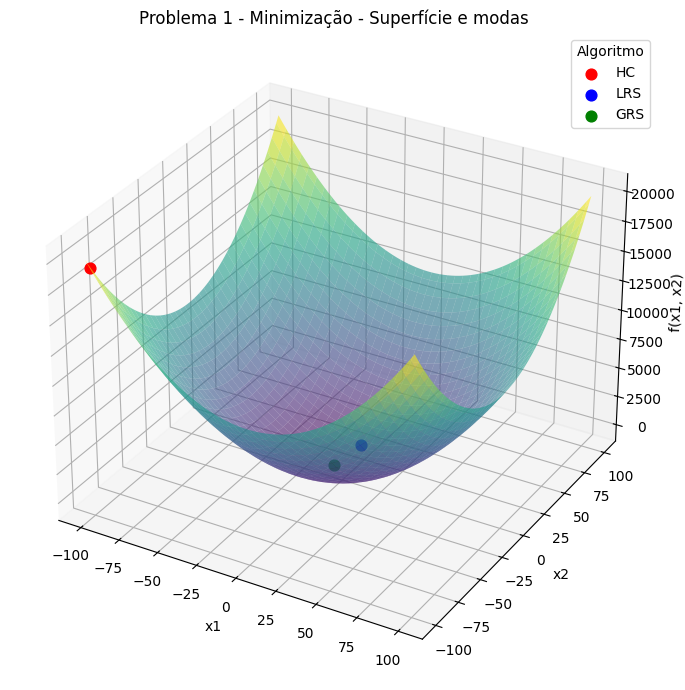

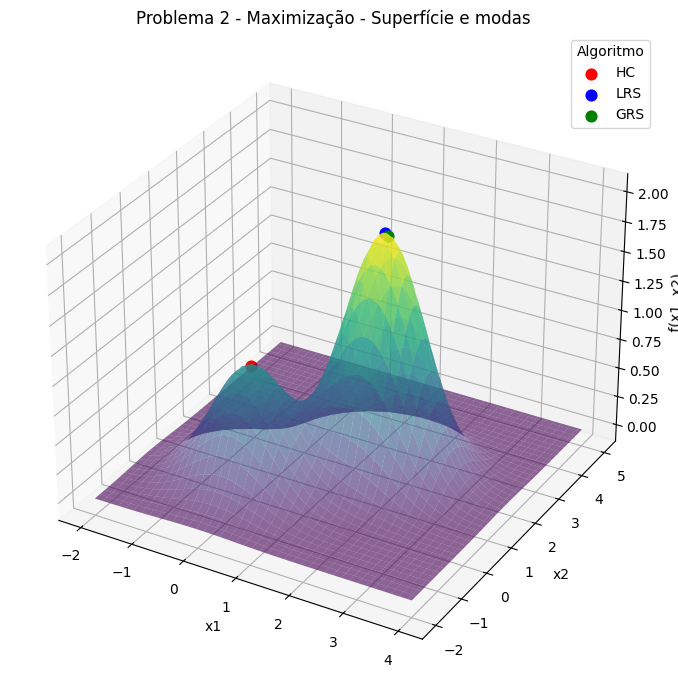

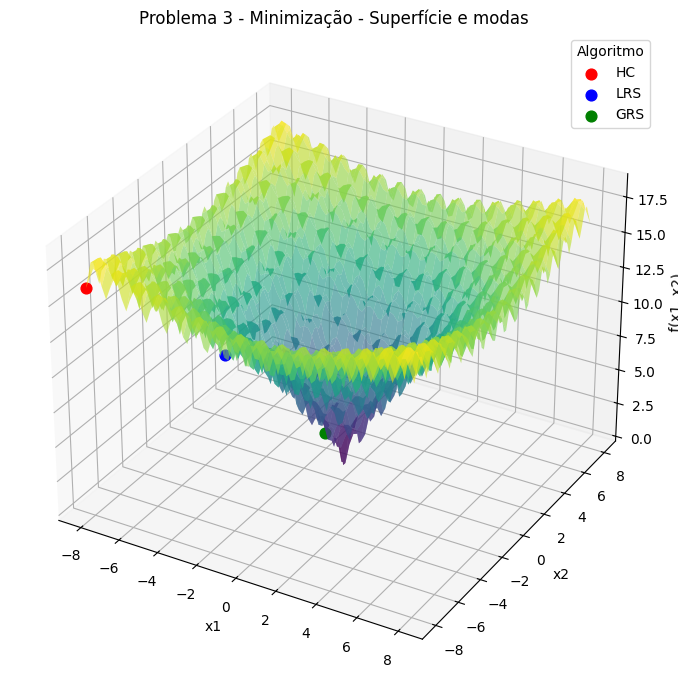

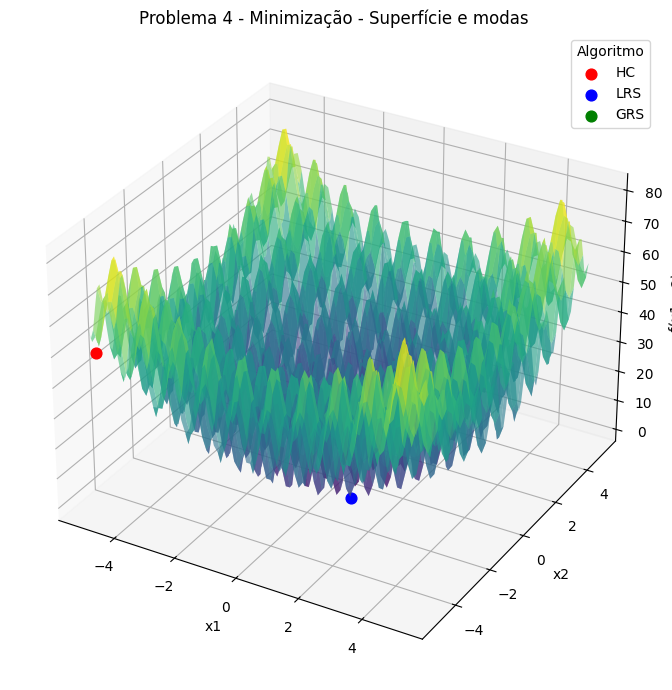

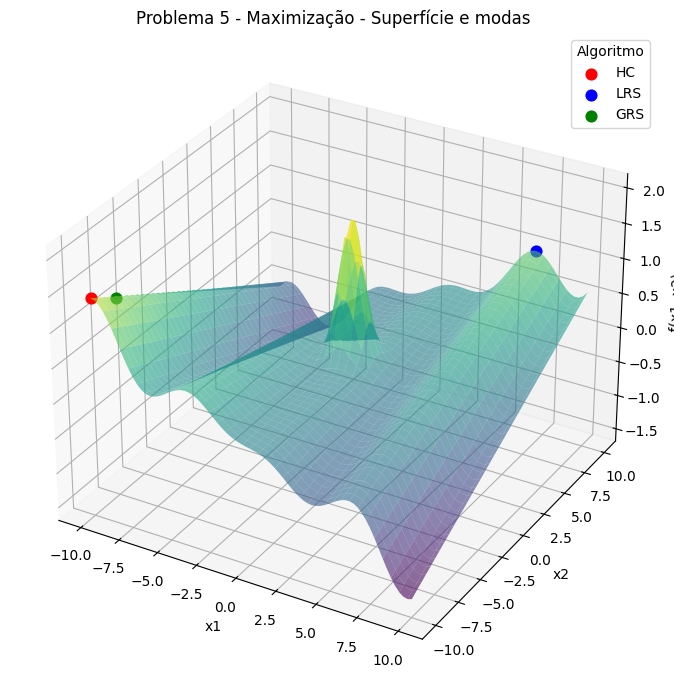

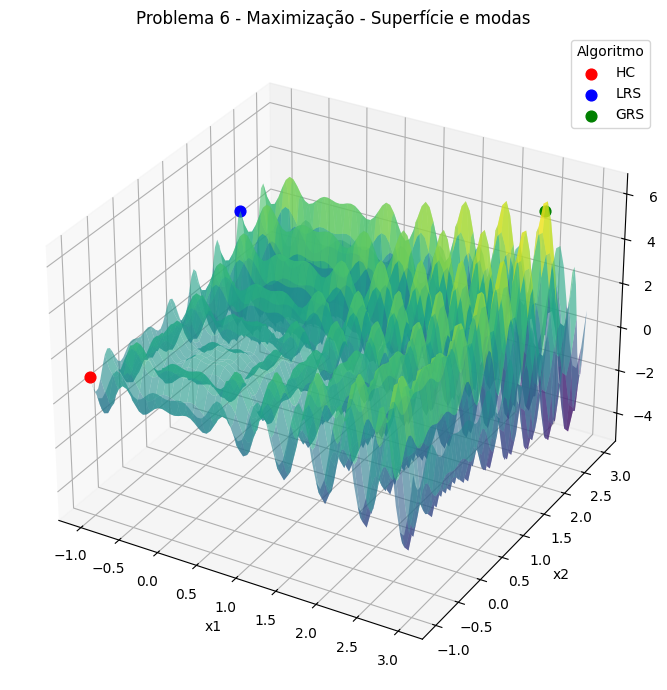

In [ ]:
# Se ainda não tiver:
df_modes = pd.DataFrame(modes_table)

def get_problem_function(problem_idx):
    func, bounds, goal = problems[problem_idx - 1]
    return func, bounds, goal

def plot_problem_with_modes(problem_idx, df_modes, grid_points=80):
    func, bounds, goal = get_problem_function(problem_idx)
    (x1_min, x1_max), (x2_min, x2_max) = bounds

    x1 = np.linspace(x1_min, x1_max, grid_points)
    x2 = np.linspace(x2_min, x2_max, grid_points)
    X1, X2 = np.meshgrid(x1, x2)

    Z = np.zeros_like(X1, dtype=float)
    for i in range(X1.shape[0]):
        for j in range(X1.shape[1]):
            Z[i, j] = func(np.array([X1[i, j], X2[i, j]]))

    df_p = df_modes[df_modes["indice_problema"] == problem_idx]

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(X1, X2, Z, cmap="viridis", alpha=0.6)

    colors = {"HC": "red", "LRS": "blue", "GRS": "green"}
    for _, row in df_p.iterrows():
        alg = row["algoritmo"]
        x_moda = row["x_moda"] 
        fx_moda = row["fx_moda"]

        ax.scatter(x_moda[0], x_moda[1], fx_moda,
                   color=colors.get(alg, "black"),
                   s=60,
                   label=alg)

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), title="Algoritmo")

    objetivo_str = "Minimização" if goal == "min" else "Maximização"
    ax.set_title(f"Problema {problem_idx} - {objetivo_str} - Superfície e modas")

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("f(x1, x2)")

    plt.tight_layout()
    plt.show()

plot_problem_with_modes(1, df_modes)
plot_problem_with_modes(2, df_modes)
plot_problem_with_modes(3, df_modes)
plot_problem_with_modes(4, df_modes)
plot_problem_with_modes(5, df_modes)
plot_problem_with_modes(6, df_modes)
